**Table of contents**<a id='toc0_'></a>    
- [Setting up data and imports](#toc1_1_1_1_1_)    
      - [Optimization Setup](#toc1_1_1_2_)    
      - [SpOPT](#toc1_1_1_3_)    
      - [PyMOO Testing](#toc1_1_1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

##### <a id='toc1_1_1_1_1_'></a>[Setting up data and imports](#toc0_)

In [1]:
import pulp


import geopandas as gpd
import pandas as pd
import numpy as np
from importlib import reload

# Importing my modules
from src.main import classes, plotting, geometry_operations, optimization_functions

In [2]:
# %store -r line_gdf_reworked
%store -r line_gdf_75
%store -r harvesteable_trees_gdf
%store -r height_gdf
%store -r anchor_trees_gdf
%store -r target_trees_gdf
%store -r line_gdf_v1

line_gdf = line_gdf_v1.copy()
# hack to extract this from the line_gdf
start_point_dict = dict(
    [(key, value.coords[0]) for key, value in enumerate(line_gdf["line_candidates"])]
)

#### <a id='toc1_1_1_2_'></a>[Optimization Setup](#toc0_)

In [3]:
bhd_series = harvesteable_trees_gdf["BHD"]
height_series = harvesteable_trees_gdf["h"].replace(",", ".", regex=True).astype(float)

In [5]:
reload(geometry_operations)
reload(optimization_functions)
reload(classes)
# Prepare the gdfs
line_gdf["line_cost"] = optimization_functions.compute_line_costs(line_gdf, uphill_yarding = True, large_yarder = True)
harvesteable_trees_gdf["cubic_volume"] = optimization_functions.compute_tree_volume(bhd_series, height_series)

# Create the optimization objects
lscp_optimization = classes.optimization_objects("name",line_gdf, harvesteable_trees_gdf, height_gdf)

#### <a id='toc1_1_1_3_'></a>[SpOPT](#toc0_)

Creating our custom problem with constraints

- Obj Func v4:
	- ```sum(harvest_time * cli_assgn_vars[cli][fac])```
		- minimize the overall harvest time between clients and the factory they are assigned too
		- ```harvest_time = yarding_distance+lateral_yarding_distance+tree_volume+harvest_intensity+slope```
	- ```sum(fac_vars[fac]*fac_cost[fac] for fac in facility_range])```
		- minimize the sum of factory costs

- Matrices:
	- Lineactiveindex = fac_vars = $[l1+l2...]$
	- linetreeactiveindex = cli_assgn_vars = $[[l1*cli1+l1*cli2...],[l2*cli1+l2*cli2+....]]$

	- fac_cost: the cost of each line
	- cli_demand: mocked variable as of now, can be changed to reflect profit of given tree

- Constraints:
	- Constraint 1:
		- Each client is only assigned to one factory: ```pulp.lpSum([cli_assgn_vars[cli][fac] for fac in facility_range]) == 1```

	- Constraint 2: 
		- Every factory that has a client assigned must be opened: ```lscp.problem += fac_vars[fac] - cli_assgn_vars[cli][fac] >= 0```



In [25]:
reload(optimization_functions)
reload(classes)

model_list = []
steps = 5
# iterate combinations of 0.1 steps for a MOO tradeoff
for i in range(1,steps):
    lscp_optimization = classes.optimization_objects("name",line_gdf, harvesteable_trees_gdf, height_gdf)
    model = optimization_functions.optimize_cable_roads(lscp_optimization, i, steps, start_point_dict)
    model_list.append(model)


object a factor 0.7
object b factor 1.3
object a factor 0.9
object b factor 1.1
object a factor 1.1
object b factor 0.9
object a factor 1.3
object b factor 0.7


In [26]:
reload(plotting)
for i in range(steps-1):
    plotting.plot_p_median_results(model_list[i], anchor_trees_gdf, target_trees_gdf, line_gdf)

In [37]:
reload(plotting)
plotting.extract_moo_model_results(model_list[0].model, line_gdf, print_results = True)

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,slope_deviation,angle_between_supports,line_length,line_cost,number_int_supports
9,4.727779,30.861134,121.161199,450.970672,0


[450]

In [27]:
reload(plotting)
pd.options.plotting.backend = "plotly"
results_df = plotting.model_results_comparison(model_list)
overall_profit_baseline = results_df.iloc[0]["overall_profit"]
display(results_df)
results_df.plot()

Profit baseline is 21362.637975639445


,Total distance of trees to cable roads,Productivity cost per m3 as per Stampfer,Total distance from carriage to support,overall_profit,cable_road_costs,profit_comparison
0,5837.171249,6163.138630,44805.567386,215.547541,1755.106386,192.116143
1,4935.993183,5351.247271,44693.283793,216.670377,2198.223304,304.399736
2,4810.532167,5210.851191,44868.461580,214.918599,2357.380646,129.221948
3,4306.566505,4932.046604,44997.683528,213.626380,2806.063948,0.000000


In [135]:
from src.main import global_vars
kdtree = global_vars.init(height_gdf)
fig = plotting.plot_3d_model_results(model_list[1].model, line_gdf, height_gdf)
fig.show("notebook_connected")

Cable road created from line:  (-15.12792573, -26.16056076) to  (-29.880646898378075, -8.757599103801436)


AttributeError: 'Support' object has no attribute 'xy_location_numpy'

In [137]:
line_gdf.iloc[0]["Cable Road Object"].start_support.xy_location_numpy

AttributeError: 'Support' object has no attribute 'xy_location_numpy'

#### <a id='toc1_1_1_4_'></a>[PyMOO Testing](#toc0_)

In [41]:
%load_ext line_profiler

In [139]:
from src.main import moo_optimization_functions
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

reload(moo_optimization_functions)

cost_matrix = model_list[0].aij
nsga_problem = moo_optimization_functions.SupportLinesProblem(cost_matrix, model_list[0].facility_cost)
termination = get_termination("n_gen",20)

reload(optimization_functions)

client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]

algorithm = NSGA2(
    pop_size=50,
    sampling=moo_optimization_functions.CustomSampling(),#initally zero matrix, nothing assigned
    mutation=moo_optimization_functions.MyMutation(),
    repair=moo_optimization_functions.MyRepair(),
)

# %prun minimize(problem,algorithm,termination,verbose=True,return_least_infeasible=True,seed=0)
res = minimize(nsga_problem,
               algorithm,
               termination,
               verbose=True,
               return_least_infeasible=True,
               seed=0)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        1 |      1 |  5.159484E+02 |  5.159484E+02 |             - |             -
     2 |       51 |      7 |  0.000000E+00 |  0.000000E+00 |             - |             -
     3 |      101 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0543068976 |         ideal
     4 |      151 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0064546013 |             f
     5 |      201 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0148676233 |         ideal
     6 |      251 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0072876285 |             f
     7 |      301 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0002870325 |             f
     8 |      351 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0283510557 |         ideal
     9 |      401 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0031137452 |             f
    10 |      451 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0006294994 |             f

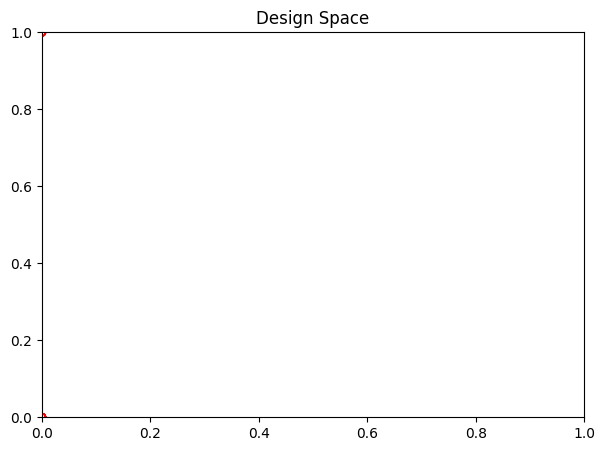

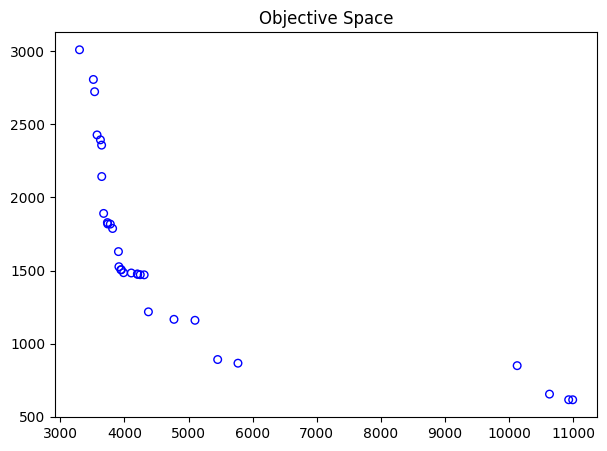

In [142]:
plotting.plot_NSGA_results(X, F, nsga_problem)

In [160]:
[x for x in X[7] if (x<1 and x>0)]

[0.005015484710045315,
 0.04569052947476254,
 0.0801297495268602,
 0.03373444190954983]

KeyboardInterrupt: 

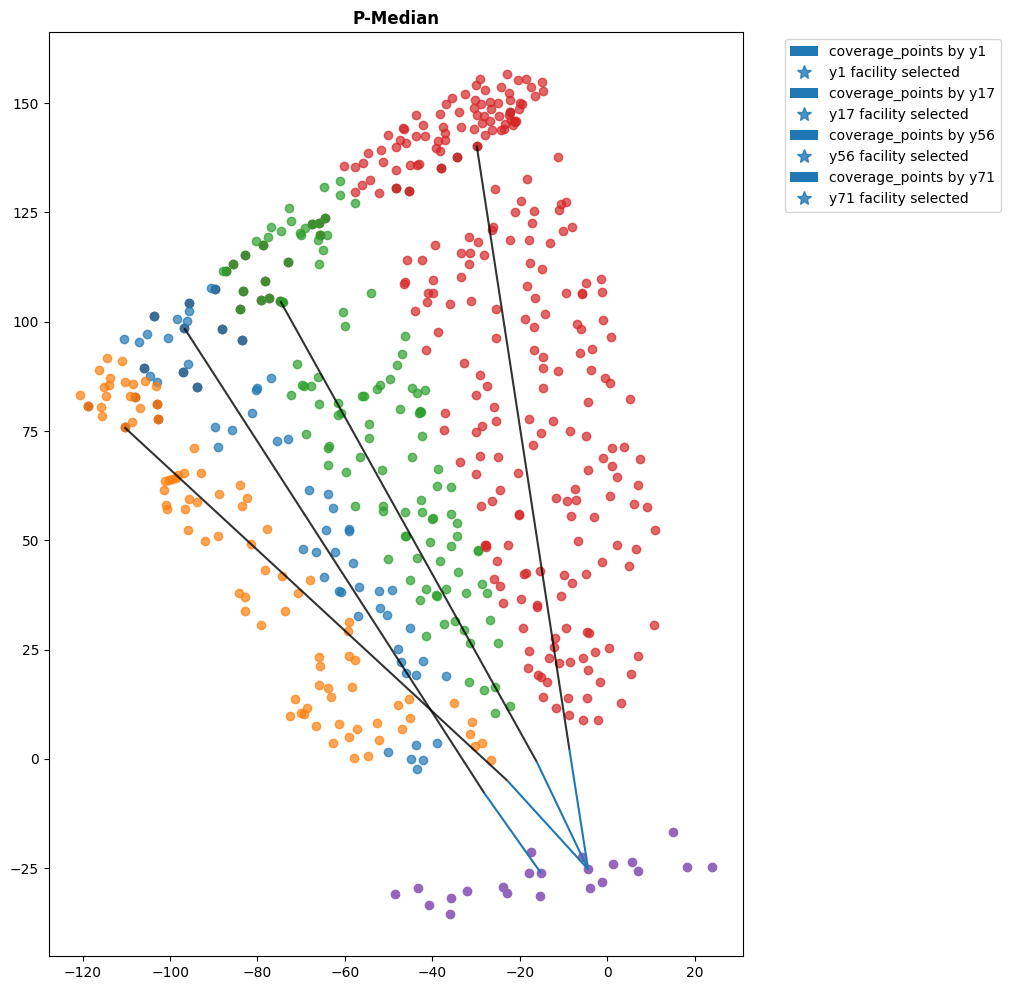

In [149]:
x_sol = X[-10]
variable_matrix = x_sol.reshape((len(model_list[0].demand_points_gdf)+1,len(line_gdf)))

# Visualizations
client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]
cli_assgn_vars = variable_matrix[:-1]
fac_vars = variable_matrix[-1:]

reload(plotting)

for x_sol in range(0,X.shape[0],4):
    plotting.plot_pymoo_results(X[x_sol], model_list[0], anchor_trees_gdf, target_trees_gdf, line_gdf)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(8,5)})

# for x_sol in range(0,X.shape[0],4):
#     plotting.plot_pymoo_results(X[x_sol], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

def plot_explain(i):
    plotting.plot_pymoo_results(X[int(i)], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

%matplotlib inline

import numpy as np

interact(plot_explain, i = widgets.FloatSlider(value=1, min=1, max=X.shape[0], step=1))

interactive(children=(FloatSlider(value=1.0, description='i', max=51.0, min=1.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_explain(i)>

In [ ]:
range(0,X.shape[0],4)

range(0, 77, 4)

### Rule Of Thumb Optimization

<AxesSubplot:>

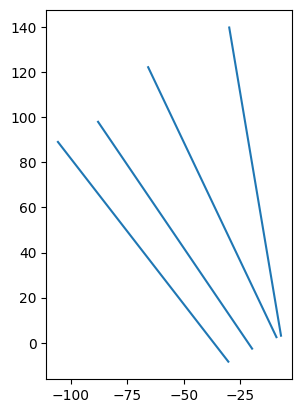

In [14]:
distance_array = np.zeros((len(line_gdf), len(line_gdf)))
                           
for index, line in line_gdf.iterrows():
    # get the distance from all trees to this line
    line_tree_distance = line_gdf.geometry.distance(line.geometry)
    distance_array[index] = line_tree_distance

# start by selecting line 10
start_index = 30
selected_lines_indices = [start_index]

# the number of additional lines we want to select
lines_to_select = 3
for line_to_select in range(lines_to_select):

    sum_selected_lines = np.sum(distance_array[:,[*selected_lines_indices]],axis=1)
    # and append its index to the list
    index_largest_line = sum_selected_lines.argmax()
    selected_lines_indices.append(index_largest_line)

    # set the distance of the selected line to zero so it won't be selected again
    distance_array[selected_lines_indices,:] = 0

rot_line_gdf = line_gdf.iloc[selected_lines_indices]
rot_line_gdf.plot()

In [24]:
# Compute the cost of this configuration
# Create a matrix with the distance between every tree and line and the distance between the support (beginning of the CR) and the carriage (cloests point on the CR to the tree)
distance_tree_line, distance_carriage_support = geometry_operations.compute_distances_facilities_clients(harvesteable_trees_gdf, rot_line_gdf)

# sort the facility (=lines) and demand points (=trees)
facility_points_gdf = rot_line_gdf.reset_index()

# create the nr of possible facilities and clients 
client_range = range(distance_tree_line.shape[0])
facility_range = range(distance_tree_line.shape[1])

# add facility cost with an optional scaling factor
facility_scaling_factor = 1
facility_cost = rot_line_gdf.line_cost.values*facility_scaling_factor

# create the aij cost matrix, which is really just the distance from the tree to the line
aij = distance_tree_line

# collect the matrices needed for the optimization
tree_volumes_list = harvesteable_trees_gdf["cubic_volume"]
angle_between_supports_list = rot_line_gdf["angle_between_supports"]

reload(geometry_operations)
average_steepness = geometry_operations.compute_average_terrain_steepness(rot_line_gdf, height_gdf)

# and the productivity cost combination of each line combination
productivity_cost = optimization_functions.calculate_felling_cost(client_range, facility_range, aij, distance_carriage_support, tree_volumes_list, average_steepness)

In [26]:
# assign all trees to their closest line
tree_to_line_assignment = np.argmin(distance_tree_line, axis=1)

# compute the distance of each tree to its assigned line
distance_trees_to_lines = sum(distance_tree_line[range(len(tree_to_line_assignment)), tree_to_line_assignment])

# compute the productivity cost
productivity_cost_overall = np.sum(lscp_optimization.productivity_cost[range(len(tree_to_line_assignment)), tree_to_line_assignment])

print(f"Total distance of trees to lines: {distance_trees_to_lines}")
print(f"Total productivity cost: {productivity_cost_overall}")
print(f"Total profit: {3591541-productivity_cost_overall}")

Total distance of trees to lines: 4417.332402660665
Total productivity cost: 3261.1518820119254
Total profit: 3588279.848117988


In [74]:
3578490-3508412

70078

<AxesSubplot:>

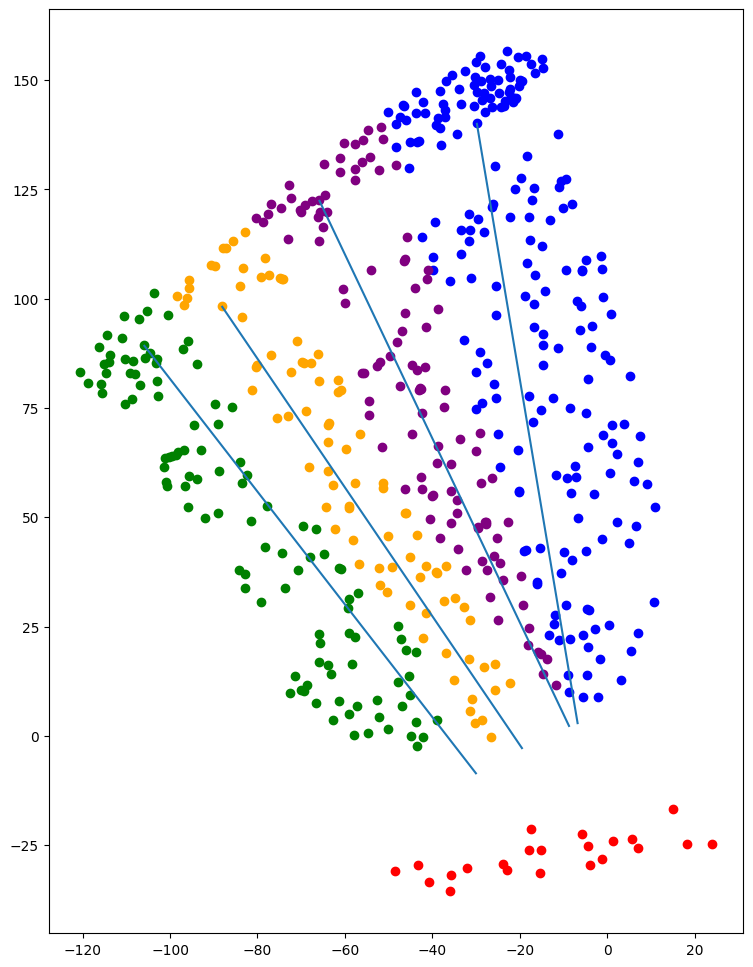

In [194]:
fig, ax = plt.subplots(figsize=(12, 12))
rot_line_gdf.plot(ax=ax)
anchor_trees_gdf.plot(ax=ax, color="red")

# terrible hack to get the corresponding rtees
group0, group1, group2, group3 = [], [], [], []
for index in range(len(tree_to_line_assignment)):
    selected_item = harvesteable_trees_gdf.iloc[index].geometry
    if tree_to_line_assignment[index] == 0:
        group0.append(selected_item)
    elif tree_to_line_assignment[index] == 1:
        group1.append(selected_item)
    elif tree_to_line_assignment[index] == 2:
        group2.append(selected_item)
    elif tree_to_line_assignment[index] == 3:
        group3.append(selected_item)

group0_gdf = gpd.GeoDataFrame(geometry=group0)
group1_gdf = gpd.GeoDataFrame(geometry=group1)
group2_gdf = gpd.GeoDataFrame(geometry=group2)
group3_gdf = gpd.GeoDataFrame(geometry=group3)

group0_gdf.plot(ax=ax, color="orange")
group1_gdf.plot(ax=ax, color="blue")
group2_gdf.plot(ax=ax, color="green")
group3_gdf.plot(ax=ax, color="purple")